<a href="https://colab.research.google.com/github/RohiniRG/Document-Similarity-Matrix/blob/main/similarity_matrix.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import spacy
nlp = spacy.load("en_core_web_sm")
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
import nltk
from nltk.tokenize import word_tokenize
nltk.download('punkt')
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np
from tabulate import tabulate
!pip install -U sentence-transformers
from sentence_transformers import SentenceTransformer, util
from matplotlib import pyplot as plt

In [42]:
articles_df = pd.read_csv("/content/historic_articles.csv")
articles_df.head()

,source,category,link,author,published_at,header,subheader,content
0,firstpost,india,https://www.firstpost.com/india/supreme-court-...,FP Staff,"September 21, 2020 20:11:56 IST","Supreme Court, in anti-CAA blockade case, says...",While listening to a batch of petitions agains...,The Supreme Court on Monday said there cannot ...
1,firstpost,india,https://www.firstpost.com/india/rti-reponse-re...,Sumit Chaturvedi,"September 20, 2020 10:02:10 IST",RTI reponse reveals over 18 lakh ration cards ...,The large backlog of pending ration card appli...,Lakhs of migrant workers who returned to their...
2,firstpost,india,https://www.firstpost.com/india/pilot-dies-as-...,Press Trust of India,"September 21, 2020 15:32:17 IST",Pilot dies as four-seater training aircraft cr...,"The aircraft, which belonged to the Indira Gan...",Azamgarh: A four-seater training aircraft cras...
3,firstpost,india,https://www.firstpost.com/india/hcl-technologi...,Press Trust of India,"September 21, 2020 14:15:16 IST",HCL Technologies to acquire Australia’s DWS Lt...,"DWS, with FY20 revenue at AUS $167.9 million, ...",New Delhi: HCL Technologies on Monday said it ...
4,firstpost,india,https://www.firstpost.com/india/parliament-mon...,FP Staff,"September 22, 2020 10:42:06 IST",Parliament LIVE Updates: Pralhad Joshi says go...,Parliament LIVE Updates: Parliamentary Affair ...,Parliament LATEST Updates: Parliamentary Affai...


In [43]:
df = articles_df[["content"]]
documents = df.head(50)
documents

,content
0,The Supreme Court on Monday said there cannot ...
1,Lakhs of migrant workers who returned to their...
2,Azamgarh: A four-seater training aircraft cras...
3,New Delhi: HCL Technologies on Monday said it ...
4,Parliament LATEST Updates: Parliamentary Affai...
5,The Lok Sabha on Monday evening passed a bill ...
6,Thane: The toll in the Bhiwandi building colla...
7,"United Nations: The United Nations faces a ""cr..."
8,The latest quarterly Gross Domestic Product da...
9,"Amid rising coronavirus cases in the country, ..."


In [46]:
def preprocessing(row):
  row = [token.lemma_.lower() for token in nlp(row) if token.is_alpha and not token.is_stop]
  return " ".join(row)

In [144]:
documents['preprocessed content'] = documents['content'].apply(preprocessing)
documents

<ipython-input-144-c3f728eb041a>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  documents['preprocessed content'] = documents['content'].apply(preprocessing)


,content,preprocessed content
0,The Supreme Court on Monday said there cannot ...,supreme court monday say universal policy righ...
1,Lakhs of migrant workers who returned to their...,lakhs migrant worker return hometown uttar pra...
2,Azamgarh: A four-seater training aircraft cras...,azamgarh seater training aircraft crash uttar ...
3,New Delhi: HCL Technologies on Monday said it ...,new delhi hcl technologies monday say acquire ...
4,Parliament LATEST Updates: Parliamentary Affai...,parliament latest update parliamentary affair ...
5,The Lok Sabha on Monday evening passed a bill ...,lok sabha monday evening pass bill amend forei...
6,Thane: The toll in the Bhiwandi building colla...,thane toll bhiwandi building collapse maharash...
7,"United Nations: The United Nations faces a ""cr...",united nations united nations face crisis conf...
8,The latest quarterly Gross Domestic Product da...,late quarterly gross domestic product datum re...
9,"Amid rising coronavirus cases in the country, ...",amid rise coronavirus case country survey reve...


##**Doc2Vec** 

In [83]:
documents_df = documents
tagged_data = [TaggedDocument(words=word_tokenize(doc), tags=[i]) for i, doc in enumerate(documents_df["preprocessed content"])]
model_d2v = Doc2Vec(vector_size=50, alpha=0.025, min_count=1, epochs=100)
model_d2v.build_vocab(tagged_data)
model_d2v.train(tagged_data, total_examples=model_d2v.corpus_count, epochs=100)
model_d2v.wv.most_similar('government')

[('responsibility', 0.5274476408958435),
 ('assistance', 0.5155417919158936),
 ('powerless', 0.5081831216812134),
 ('education', 0.5063667297363281),
 ('stop', 0.4911736845970154),
 ('moral', 0.48694777488708496),
 ('territory', 0.46875879168510437),
 ('actual', 0.4672238528728485),
 ('subject', 0.4632646143436432),
 ('announce', 0.46026811003685)]

In [91]:
similarity_matrix = [[0 for i in range(50)] for i in range(50)]
for i, row in documents_df.iterrows():
  s1 = row["preprocessed content"].split(" ")
  for j, row in documents_df.iterrows():
    s2 = row["preprocessed content"].split(" ")
    cosine_score = model_d2v.wv.n_similarity(s1, s2)
    similarity_matrix[i][j] = cosine_score
print(tabulate(similarity_matrix))

--------  --------  --------  --------  --------  --------  --------  --------  --------  --------  --------  --------  --------  --------  --------  --------  --------  --------  --------  --------  --------  --------  --------  --------  --------  --------  --------  --------  --------  --------  --------  --------  --------  --------  --------  --------  --------  --------  --------  --------  --------  --------  --------  --------  --------  --------  --------  --------  --------  --------
1         0.372407  0.504654  0.350923  0.605651  0.672225  0.413944  0.465881  0.394289  0.416667  0.556462  0.712499  0.337229  0.364608  0.592332  0.382744  0.315567  0.379797  0.739031  0.557434  0.482427  0.422953  0.349261  0.347032  0.524922  0.330366  0.350923  0.591939  0.573409  0.341451  0.46752   0.575126  0.441428  0.608921  0.552968  0.729716  0.610875  0.62817   0.625783  0.643034  0.653443  0.559789  0.494387  0.557701  0.398687  0.418488  0.518215  0.811308  0.537708  0.650637
0.

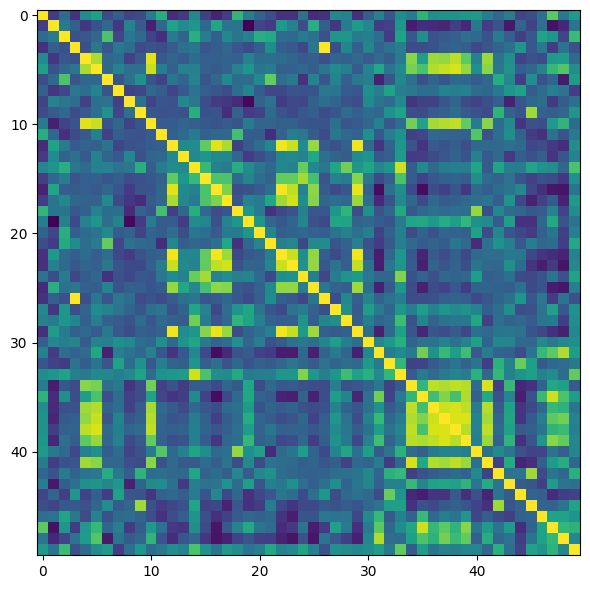

In [103]:
fig, ax = plt.subplots(figsize=(6, 6))
ax.imshow(similarity_matrix, interpolation='nearest', aspect='auto')
plt.tight_layout()

In [115]:
test_article = df.iloc[50]['content']
test_article

'India\'s single-day recovery exceeded the number of new infections as nearly 96,000 people recuperated from the novel coronavirus, even as the total caseload went past 53 lakh, according to the Union Health Ministry data updated on Saturday.With this, the country also crossed United States to register the highest number of COVID-19 recoveries in the world.The figures released at 8 am Saturday showed that while 95,880 people recovered from COVID-19 in a span of 24 hours, 93,337 new infections were recorded during the period.\xa0The death toll, meanwhile, climbed to 85,619 with the virus claiming 1,247 lives in a span of 24 hours, the updated data showed.The 1,247 new deaths reported on Saturday include 440 from Maharashtra, 179 from Karnataka, 98 from Uttar Pradesh, 67 each from Andhra Pradesh and Tamil Nadu, 62 from Punjab, 59 from West Bengal, 31 from Puducherry and 30 from Delhi.The COVID-19 case fatality rate has further dropped at 1.61 percent. There are 10,13,964 active cases of 

In [117]:
new_vector = model_d2v.infer_vector(test_article.split())
sims = model_d2v.docvecs.most_similar([new_vector])
for i in sims:
  print(i[1], " ===> ", documents_df.iloc[i[0]]["content"])

0.4846321642398834  ===>  The ICMR is actively exploring saliva-based test for detection of COVID-19, Union Health Minister Harsh Vardhan said on Sunday and asserted that no significant or drastic mutation in strains of SARS-CoV-2 has been found in India till now.During an interaction with his social media followers, Vardhan informed them the Indian Council of Medical Research (ICMR) has been conducting large-scale sequencing of nationally representative strains of SARS-CoV-2 virus collected for several months over different time-points.Detailed results on mutations and evolution of the virus will be available in early October, he said.Replying to queries during the 'Sunday Samvad' platform, Vardhan further said enough oxygen is being produced in the country and the health ministry is closely monitoring the situation.According to a health ministry statement, he reminded everyone that the ministry had dispatched oxygen concentrators to rural parts of the country, to avert the logistic i

<ipython-input-117-a8170937c026>:2: DeprecationWarning: Call to deprecated `docvecs` (The `docvecs` property has been renamed `dv`.).
  sims = model_d2v.docvecs.most_similar([new_vector])


##**BERT** 

In [120]:
sbert_model = SentenceTransformer('bert-base-nli-mean-tokens')
documents_df = documents
document_embeddings = sbert_model.encode(documents_df["preprocessed content"])

In [125]:
cosine_scores = util.cos_sim(document_embeddings, document_embeddings)
print(tabulate(cosine_scores))

--------  --------  --------  --------  --------  --------  --------  --------  --------  --------  --------  --------  --------  --------  --------  --------  --------  --------  --------  --------  --------  --------  --------  --------  --------  --------  --------  --------  --------  --------  --------  --------  --------  --------  --------  --------  --------  --------  --------  --------  --------  --------  --------  --------  --------  --------  --------  --------  --------  --------
1         0.786036  0.675829  0.616568  0.843273  0.851894  0.737701  0.84689   0.730765  0.660485  0.834049  0.853809  0.753012  0.677321  0.649647  0.638009  0.73121   0.768563  0.772415  0.78962   0.515823  0.749721  0.789697  0.785386  0.787799  0.737857  0.616568  0.796391  0.766025  0.722851  0.72935   0.770402  0.759192  0.788117  0.825041  0.808125  0.769757  0.83458   0.812857  0.821261  0.58726   0.834165  0.580127  0.810507  0.722307  0.708274  0.773033  0.825492  0.735134  0.816816
0.

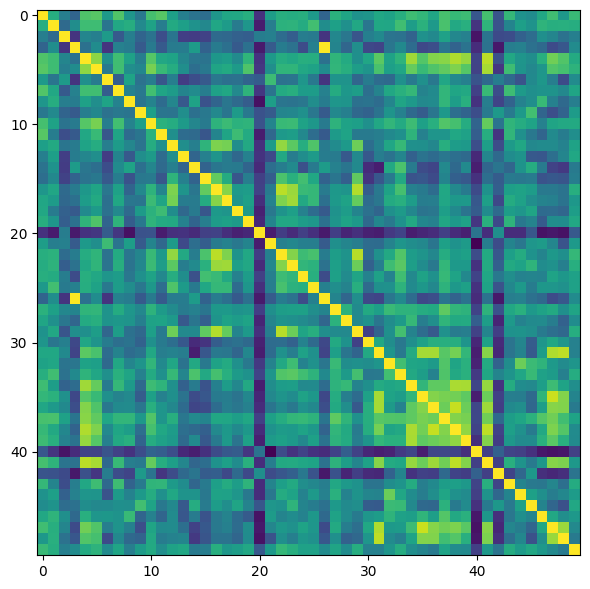

In [126]:
fig, ax = plt.subplots(figsize=(6, 6))
ax.imshow(cosine_scores, interpolation='nearest', aspect='auto')
plt.tight_layout()

In [128]:
test_article = df.iloc[50]['content']
test_article = preprocessing(test_article)

In [129]:
test_article

'india single day recovery exceed number new infection nearly people recuperate novel coronavirus total caseload go past lakh accord union health ministry datum update saturday country cross united states register high number recovery world figure release saturday show people recover span hour new infection record period death toll climb virus claim life span hour update datum show new death report saturday include maharashtra karnataka uttar pradesh andhra pradesh tamil nadu punjab west bengal puducherry delhi case fatality rate drop percent active case country constitute percent total caseload datum state worst hit state maharashtra andhra pradesh tamil nadu karnataka iii clinical trial oxford vaccine candidate begin mondayserum institute india sii begin phase iii human trial oxford university vaccine sassoon general hospital pune week furthermore central government say vaccine candidate india advanced stage testing phase iii trial covishield vaccine begin sassoon hospital week likel

In [130]:
test_embeddings = sbert_model.encode(test_article)
score = util.cos_sim([test_embeddings], document_embeddings)

/usr/local/lib/python3.10/dist-packages/sentence_transformers/util.py:36: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:245.)
  a = torch.tensor(a)


In [143]:
scores = list(enumerate(score[0]))
results = sorted(scores,key=lambda x:(-x[1],x[0]))[:10]
for i in results:
  print(i[1], " ===> ", documents_df.iloc[i[0]]["content"])

tensor(0.8906)  ===>  The coronavirus cases in India raced past 54 lakh on Sunday with 92,605 more testing positive as schools in some states prepared to partially reopen for students from classes 9 to 12  who wish to seek guidance from their teachers.Meanwhile, Chhattisgarh's Raipur is set to go under a weeklong stricter lockdown from Monday to control the spread of the infection, as per PTI.Single-day recoveries exceed new cases India's single-day recoveries exceeded the number of new infections with 94,612 people recuperating from COVID-19 in 24, taking the rceovery rate to 79.68 percent. The total COVID-19 recoveries have reached 43,03,043.As many as 60 percent of the new recoveries were reported from five states — Maharashtra, Karnataka, Andhra Pradesh, Uttar Pradesh and Tamil Nadu.Maharashtra continued to top the chart with more than 23,000 new recoveries, while both Karnataka and Andhra Pradesh accounted for over 10,000 single-day recoveries, it said.The COVID-19 caseload in the